# NN track reco on pseudodata

The data input and NN architecture are largely following the HEPTrkX example.
The input here is including all straws for each event, which may be inefficient and alternatives should be explored.

## Generate straw tracker pseudodata

In [2]:
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [7]:
class Detector():
    """
    Simulate a 2D rectangular straw setup.
    Made of successive modules, each one consisting of U/V double layers of straws.
    """
    n_modules=8 ## number of modules, each with 4 layers of straws
    n_layersPerModule=4
    n_layers = n_modules*n_layersPerModule
    n_straws=32 #or 16, or 24 -- allow for variable number of straws per layer
    
    straw_radius=0.5 # [cm]
    straw_distance=1.2 # distance between neighboring straw centers in same layer [cm]
    UV_distance=2   # distance between successive U/V submodules [cm]
    module_distance=7   # distance between successive modules [cm]
    yOffset_PerModule = 5 # y-offset per module, to allow for inward bend of tracks

    module_length = (n_layersPerModule/2)*straw_distance + UV_distance + 2*straw_radius
    length=n_modules*module_length + (n_modules-1)*module_distance
    width=n_straws*straw_distance+2*straw_radius
    
    ## Occupancy characteristics
    avg_tracks=2 ## avg number of tracks per event
    max_tracks=4 ## max number of tracks allowed per event

    
    layers=np.zeros(n_layers)
    straws=np.zeros(n_straws)
    x=np.zeros(n_layers)
    y=np.zeros((n_layers, n_straws))
    
    def make_straws(self):
        ## returns the x,y (length,width) vectors of straw locations
        for i_module in range(self.n_modules):
            for i_layer in range(self.n_layersPerModule):
                layer = i_module*self.n_layersPerModule + i_layer
                self.layers[layer]=layer
                layer_x = i_module*self.module_length + self.straw_radius
                if i_module>0: layer_x += i_module*self.module_distance
                if i_layer>=1: layer_x += self.straw_distance
                if i_layer>=2: layer_x += self.UV_distance
                if i_layer==3: layer_x += self.straw_distance
                self.x[layer] = layer_x
                ## vertical stagger for this layer:
                if (i_layer==1) or (i_layer==2):  stagger = self.straw_distance/2
                else: stagger=0
                for i_straw in range(self.n_straws):
                    #if (i_module<=2) and (i_straw>=16): continue
                    #if (i_module<=5) and (i_straw>=24): continue
                    if i_module==8: self.straws[i_straw]=i_straw
                    self.y[layer][i_straw]=i_module*self.yOffset_PerModule + i_straw*self.straw_distance + stagger

In [8]:
tracker=Detector()
tracker.make_straws()
print (tracker.x, '\n', tracker.y)

[ 0.5  1.7  3.7  4.9 12.9 14.1 16.1 17.3 25.3 26.5 28.5 29.7 37.7 38.9
 40.9 42.1 50.1 51.3 53.3 54.5 62.5 63.7 65.7 66.9 74.9 76.1 78.1 79.3
 87.3 88.5 90.5 91.7] 
 [[ 0.   1.2  2.4 ... 34.8 36.  37.2]
 [ 0.6  1.8  3.  ... 35.4 36.6 37.8]
 [ 0.6  1.8  3.  ... 35.4 36.6 37.8]
 ...
 [35.6 36.8 38.  ... 70.4 71.6 72.8]
 [35.6 36.8 38.  ... 70.4 71.6 72.8]
 [35.  36.2 37.4 ... 69.8 71.  72.2]]


In [9]:
def display_event(detector, straw_hits=None, track_ids=None, figsize=(15, 8)):
    """
    Draw hits and tracks from a single event (time window) in detector.
    Parameters:
        detector: The DetectorGeometry object
        straw_hits: 2D array with the straws that are hit in the event
        track_ids: The track identifier corresponding to each hit
    """

    fig, ax = plt.subplots(figsize=figsize) # note we must use plt.subplots, not plt.subplot
    
    full_width = detector.width + detector.n_modules * detector.yOffset_PerModule
    ax.set_xlim((-0.1*detector.length, 1.1*detector.length))
    ax.set_ylim((-0.1*full_width, 1.1*full_width))

    ## plot a circle at the location of each straw
    for i_layer in range(detector.n_layers):
        for i_straw in range(detector.n_straws):
            if (detector.x[i_layer]==0) or (detector.y[i_layer][i_straw]==0): continue
            circle = plt.Circle((detector.x[i_layer], detector.y[i_layer][i_straw]), detector.straw_radius, color='black', fill=False)
            ax.add_patch(circle)
    
    if straw_hits is not None:
        ## plot all hits
        layers,straws=np.where(straw_hits==1)
        ax.scatter(detector.x[layers],detector.y[layers,straws], marker='.', color='black')

    if track_ids is not None:
        ## plot all tracks with a separate color
        for itrack in range(1,int(np.max(track_ids))+1):
            layers,straws=np.where(track_ids==itrack)
            plt.scatter(detector.x[layers],detector.y[layers,straws], marker='o', label='track %d'%itrack)
        
        ## plot unassigned hits if they exist
        if -1 in track_ids:
            layers,straws=np.where(track_ids==-1)
            plt.scatter(detector.x[layers],detector.y[layers,straws], marker='o', color='black', label='unassigned hits')



    plt.legend(loc=1)
    plt.show()


No handles with labels found to put in legend.


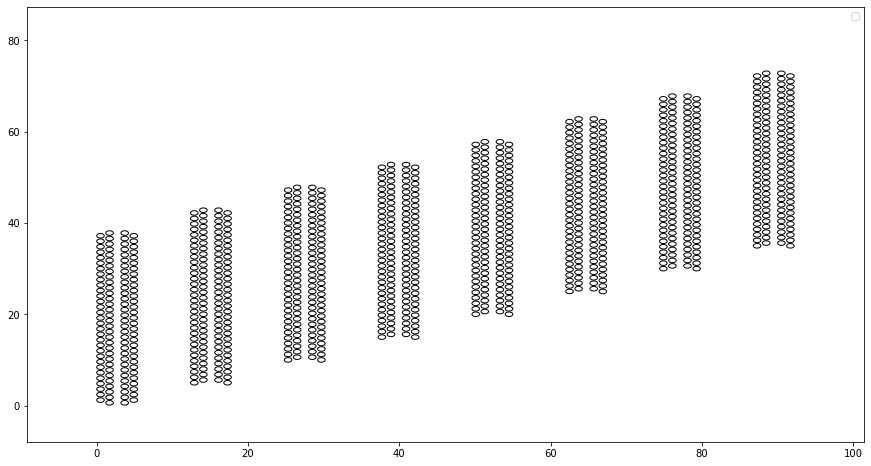

In [10]:
display_event(tracker)

## Generate fake tracks

In [11]:
def simulate_straight_track(intercept, slope, detector):
    """
    Simulate detector data for one straight track.
    Parameters:
        slope: track slope parameter [cm/cm]
        intercept: track intercept parameter [cm]
        detector: A Detector_Geometry that holds the straw positions
    Returns:
        straw_hits: ndarray of hit straws for one straight track
    """
    straw_hits= np.zeros((detector.n_layers,detector.n_straws))
    for ilayer,straw_x in enumerate(detector.x):
        for istraw,straw_y in enumerate(detector.y[ilayer]):
            if (straw_x==0) or (straw_y==0): continue
            ## check each straw to see if it is hit by the track
            track_y = intercept + slope*straw_x
            ## this only identifies a track if it intersects the straw at x=straw_x, which may miss some hits.
            ## instead for full accuracy should consider something like:
            ## sqrt( (track_x-straw_x)**2 + (track_y-straw_y)**2 )<straw_radius,
            ## where track_x, track_y are given by a function.
            ## that would require a function minimization, see eg: 
            ## https://stackoverflow.com/questions/18965195/find-minimum-and-maximum-values-of-a-function
            if np.abs( track_y - straw_y )<detector.straw_radius:
                straw_hits[ilayer][istraw]=1
                break
    return straw_hits


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


No handles with labels found to put in legend.


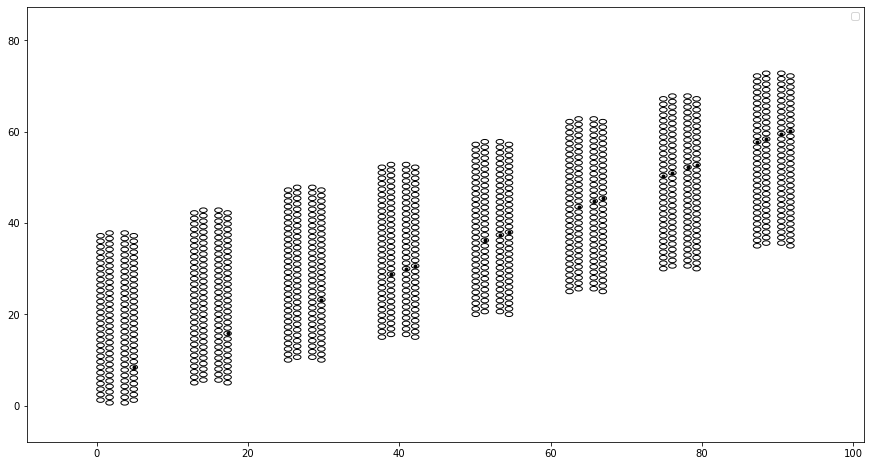

In [12]:
straw_hits = simulate_straight_track(5,0.6,tracker)
print(straw_hits)
display_event(tracker,straw_hits)

In [38]:
'''
Use this as generator 

# Generator for single track
def generate_track(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        ms = (b2s-bs)/det_depth*slope_scale # scaled slope
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        targets = zip(bs, ms)
        for i, (b, m) in enumerate(targets):
            tracks[i,0] = simulate_straight_track(m/slope_scale, b, det_shape)
        targets = np.asarray(targets)
        yield tracks, targets
'''

'\nUse this as generator \n\n# Generator for single track\ndef generate_track(batch_size=batch_size, det_shape=det_shape):\n    """Arguments: \n         batch_size: number of events to yield for each call\n       Yields: batches of training data for use with the keras fit_generator function\n    """\n    while True:\n        # Entry and exit points are randomized\n        bs = np.random.random_sample(size=batch_size)*det_width\n        b2s = np.random.random_sample(size=batch_size)*det_width\n        ms = (b2s-bs)/det_depth*slope_scale # scaled slope\n        tracks = np.zeros((batch_size, 1, det_depth, det_width))\n        targets = zip(bs, ms)\n        for i, (b, m) in enumerate(targets):\n            tracks[i,0] = simulate_straight_track(m/slope_scale, b, det_shape)\n        targets = np.asarray(targets)\n        yield tracks, targets\n'

In [27]:
def simulate_window_tracks(ntracks, detector, single_track_simulator=simulate_straight_track):
    """
    Simulate detector data for one time window.
    Parameters:
        ntracks: Number of tracks to be generated within the window
        detector: A Detector_Geometry that holds the straw positions
        track_simulator: Function that simulates individual tracks
    Returns:
        straw_hits: ndarray of hit straws for all tracks
        track_ids: ndarray where each hit is assigned an id based on the track it belongs to
        
    *** To do:
        * add noise hits, based on some parameter in Detector
    """
    
    ## intercept, slope randomization range
    int_low,int_high=detector.y[0,0]-detector.width/10, detector.y[0,-1]+detector.width/10
    slope_high = 0.5* detector.width/detector.length
    slope_low = -slope_high
    
    straw_hits= np.zeros((detector.n_layers,detector.n_straws))
    track_ids= np.zeros((detector.n_layers,detector.n_straws))

    itrack=0
    for i in range(ntracks):
        intercept=np.random.uniform(int_low,int_high)
        slope=np.random.uniform(slope_low,slope_high)
        
        straw_hits_track = simulate_straight_track(intercept,slope,detector)
        straw_hits[straw_hits_track>0]=1
        if np.sum(straw_hits_track)>3:
            itrack+=1
            track_ids[straw_hits_track>0]=int(itrack)
        else:
            track_ids[straw_hits_track>0]=-1
    return straw_hits, track_ids
        

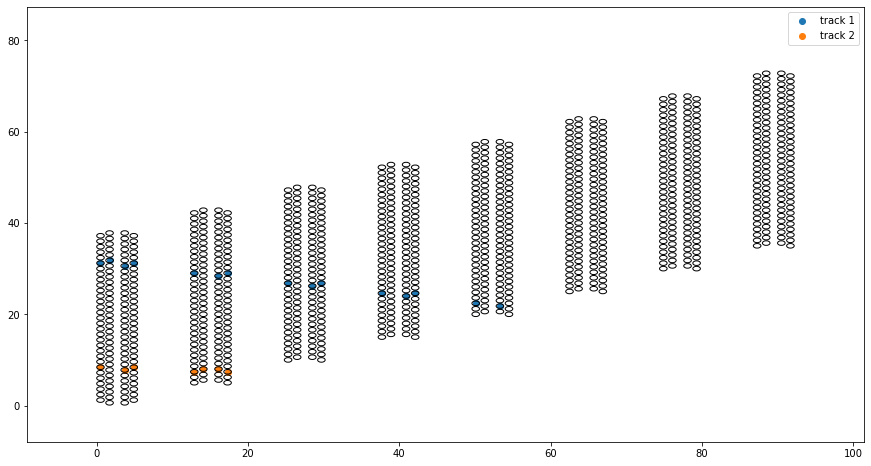

In [14]:
straw_hits, track_ids=simulate_window_tracks(3,tracker)
display_event(tracker,straw_hits,track_ids)

In [28]:
def make_seeds(ids):
    """
    Generate seeds.
    Seeds are defined for now as: at least 3 hits on the first 4 layers (1st module) from the same track.
    Parameters:
        ids: 2D array of track ids within a window
        #detector: The Detector_Geometry geometry object holds the straw positions and occupancy characteristics
    Returns:
        A 2D array (same dimension as ids, for simplicity) with seeds in first two layers.
    """
    
    seeds=np.zeros_like(ids)
    ntracks=int(np.max(ids))
    for i_track in range(1,ntracks+1):
        nHits_inFirstModule=0
        for i_layer in range(4):
            if (i_track in ids[i_layer,:]):
                nHits_inFirstModule+=1
        if (nHits_inFirstModule>=3):
            ## this track has >=3 hits in the first 4 layers, forming a seed
            ix,iy=np.where(ids==i_track)
            for i_layer in range(4):
                if len(iy[ix==i_layer])>0:
                    seeds[i_layer][iy[ix==i_layer][0]]=int(i_track)
    
    return seeds


## Create many windows/events

We need many events for training and testing.
Create many windows, with random number of tracks in each.

In [29]:
def simulate_events(n_evts, detector):
    """
    Simulate event windows.
    Parameters:
        n_evts: Number of events to simulate
        detector: The Detector_Geometry geometry object holds the straw positions and occupancy characteristics
    Returns:
        A series of straw_hits, track_ids (these are the per-event arrays):
        events_hits: [n_evts, (det_shape)] array of hit straws for all tracks in each event
        events_ids: track_ids, same shape as events_hits
    """
    
    evts_hits,evts_ids=[],[]

    for i_evt in range(n_evts):
        
        ## randomize number of tracks in this event
        ntracks=min( detector.max_tracks, np.random.poisson(detector.avg_tracks) )
        
        hits,ids=simulate_window_tracks(ntracks, detector)
        if np.sum(hits)>0:## extremely unlikely but possible
            evts_hits+=[hits]
            evts_ids+=[ids]
        
    return np.array(evts_hits), np.array(evts_ids)



In [44]:
n_training_events=80000

In [45]:
evts_hits, evts_ids = simulate_events(n_training_events,tracker)

In [46]:
evts_ids.shape

(66904, 32, 32)

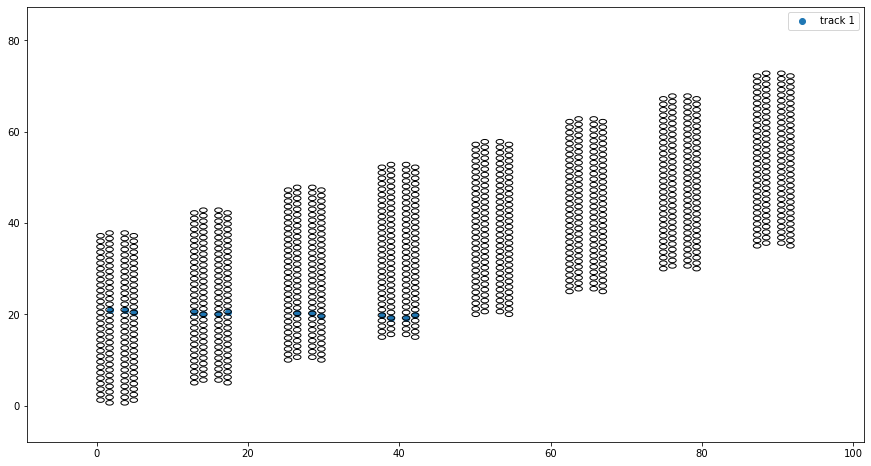

In [47]:
i_evt=0
display_event(tracker, evts_hits[i_evt], evts_ids[i_evt])

## Format data exactly as in HEPTrkX

In [34]:
import keras

In [62]:
from sklearn.base import BaseEstimator
class Clusterer(BaseEstimator):
    def __init__(self, hidden_dim=50,
                 batch_size=128, n_epochs=5, val_frac=0.1, detector=tracker):
        """
        LSTM model example.
        TODO: fill in more details.
        """
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.val_frac = val_frac
        self.detector=detector
        
        self.model=None

        self.train_input = None
        self.train_target = None
        self.prepared = False

    def build_model(self, 
                    loss='categorical_crossentropy',
                    optimizer='Nadam', metrics=['accuracy']):
        n_hidden=self.hidden_dim
        length=self.detector.n_layers
        width=self.detector.n_straws
        inputs = keras.layers.Input(shape=(length, width))
        hidden = keras.layers.LSTM(n_hidden, return_sequences=True)(inputs)
        ## could try adding more LSTM layers, with dropout inbetween to prevent overfitting
        #model.add(Dropout(0.2))
        #model.add(LSTM(n_hidden, return_sequences = True))
        #model.add(Dropout(0.2))
        outputs = keras.layers.TimeDistributed( keras.layers.Dense(width, activation='softmax'))(hidden)
        self.model = keras.Model(inputs, outputs)
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)            
            

        
    def prepare_training_data(self, evts_hits, evts_ids):
        """
        Prepare training data. 
        Reads in 3D arrays of hits and ids in many event windows.
        The 1st dimension is the event number.
        The hits and ids within each window  are of the same shape: (length,width).
        Within each window generate seeds.
        Training input and target are prepared in the same way as the HEPTrkX example.
        The input will be of shape (n_seeds, length, width)
        """
        if self.prepared: return
        self.prepared = True
        
        n_events = evts_hits.shape[0]
        n_seeds = 0 # this will be a counter for seeds we find
        max_seeds = n_events * self.detector.max_tracks
        print_freq = int(max_seeds / 20)


        
        holder_input = np.zeros((max_seeds, 
                                 self.detector.n_layers, 
                                 self.detector.n_straws))
        holder_target = np.zeros_like(holder_input)
    
        ## Iterate over all windows (events)
        for i_evt in range(n_events):
            
            ## Get all seeds in this event
            seeds=make_seeds(evts_ids[i_evt])
            seed_ids = np.unique([x for x in seeds[0] if x>0])
            n_seeds_evt = len(seed_ids)

            for i_seed in seed_ids:
                ## format input for this seed
                
                ## first turn on the seed hits after finding their (layer,straw) location
                seed_layers,seed_straws = np.where(seeds==i_seed)
                for i,ilayer in enumerate(seed_layers):
                    istraw=seed_straws[i]
                    holder_input[n_seeds][ilayer][istraw] = 1    

                ## now turn on all the non-seed hits in the event
                ilayers,istraws=np.where((evts_hits[i_evt]>0) & (seeds==0)) # this excludes other seeds
                for i,ilayer in enumerate(ilayers): ## could modify this to skip all first few layers, even for hits that arent seeds
                    #if ilayer<4: continue
                    istraw=istraws[i]
                    holder_input[n_seeds][ilayer][istraw] = 1
                    
                ## now set the target as an image of all hits from the same track as the seed
                track_id = evts_ids[i_evt][seed_layers[0]][seed_straws[0]]
                ilayers,istraws=np.where((evts_ids[i_evt]==track_id))
                for i,ilayer in enumerate(ilayers):
                    istraw=istraws[i]
                    holder_target[n_seeds][ilayer][istraw] = 1
                
                ## finished processing this seed, increment
                n_seeds += 1
                if (n_seeds % print_freq == 0):
                    print (' Processing seed #', n_seeds)
            
        print ('\nTotal seeds processed: ', n_seeds)
              
        ## Now remove all the extra array dimensions, keep only n_seeds
        self.train_input = holder_input[:n_seeds,:,:]
        self.train_target = holder_target[:n_seeds,:,:]
            

            
    def fit(self, evts_hits, evts_ids):
        #self.prepare_training_data_NoDF(evts_hits, evts_ids)
        self.prepare_training_data(evts_hits, evts_ids)
        print('Starting training...')
        self.history = self.model.fit(
            self.train_input, self.train_target,
            batch_size=self.batch_size, epochs=self.n_epochs,
            validation_split=self.val_frac)

      
    def prepare_event_for_prediction(self, evt_ids):
        """
        After the model has been trained, we will want to predict individual events.
        This function processes the 2D arrays of individual events in the proper format for model.predict().
        Reads in 2D arrays of hits and ids in the event, both of shape: (length,width).
        Find and generate seeds.
        Training input and target are prepared in the same way as the HEPTrkX example.
        The input for prediction will be of shape (n_seeds, length, width)
        """
        
        ## First form seeds in the event
        seeds=make_seeds(evt_ids)
        seed_ids = np.unique([x for x in seeds[0] if x>0])
        n_seeds = len(seed_ids)
        
        ## Input format
        model_input = np.zeros((n_seeds, 
                                self.detector.n_layers,  
                                self.detector.n_straws))

        input_seed=0 ## counter for seeds; must equal n_seeds eventually

        for i_seed in seed_ids:
            ## format input for this seed
                
            ## first turn on the seed hits after finding their (layer,straw) location
            ilayers,istraws = np.where(seeds==i_seed)
            for i,ilayer in enumerate(ilayers):
                istraw=istraws[i]
                model_input[input_seed][ilayer][istraw] = 1    
            
            ## now turn on all the non-seed hits in the event
            ilayers,istraws=np.where((evt_ids>0) & (seeds==0))
            for i,ilayer in enumerate(ilayers):
                #if ilayer<4: continue
                istraw=istraws[i]
                model_input[input_seed][ilayer][istraw] = 1
                
            ## finished processing this seed, increment
            input_seed += 1
            
        #print ('\nSeeds processed: ', input_seed)
        return model_input
    
        
    def cleanup_event_prediction(self, model_input, model_prediction):
        """
        Cleanup the model's prediction.
        Note that input and prediction are expected to be both for a single event.
        The first dimension is equal to the number of seeds in the event. 
        * Set all straws that weren't hit to 0
        * Disambiguate straw hits that are assigned to multiple tracks
        * Round probabilistic track assignment to binary yes/no
        """
        ## First set all straws that weren't hit to 0
        model_prediction[np.where((model_input==0))] = 0
        
        model_prediction_rounded = np.around(model_prediction)
        
        n_seeds=model_input.shape[0]
        if n_seeds<=1: # no disambiguation needed
            return model_prediction_rounded

        ## Disambiguate doubly assigned straw hits
        for i_seed in range(n_seeds):
            ## Here we should also assign input seeds definitely in output
            ## (though that ultimately depends on seed format)

            ## Check for ambiguities with all other tracks in event
            for i_seed_check in [x for x in range(n_seeds) if x!=i_seed]:
                ilayers,istraws = np.where((model_prediction_rounded[i_seed]>0) &
                                           (model_prediction_rounded[i_seed]== model_prediction_rounded[i_seed_check]))
                if len(ilayers)==0: continue
                for i,ilayer in enumerate(ilayers):
                    istraw=istraws[i]
                    if model_prediction[i_seed][ilayer][istraw]>model_prediction[i_seed_check][ilayer][istraw]:
                        model_prediction[i_seed_check][ilayer][istraw]=0
                    else:
                        model_prediction[i_seed][ilayer][istraw]=0
                
        model_prediction_rounded = np.around(model_prediction)        
        return model_prediction_rounded
                
        
        
    def predict_event_ids(self, evt_hits, evt_ids):
        """
        After the model has been trained, predict all tracks in a single event.
        This function returns a 2D array predicted_ids, in the same 2D format as evt_ids.
        Reads in 2D arrays of hits and ids in the event, both of shape: (length,width).
        """
        ## Prepare 2D output
        predicted_ids = np.zeros_like(evt_ids)

        ## First get seeds in the event
        seeds=make_seeds(evt_ids)
        seed_ids = np.unique([x for x in seeds[0] if x>0])
        n_seeds = len(seed_ids)
        if n_seeds==0: return predicted_ids
        
        ## Format model input for event
        model_input = self.prepare_event_for_prediction(evt_ids)

        ## Get model prediction
        model_prediction = self.model.predict(model_input)
        
        ## Cleanup the prediction
        model_prediction = self.cleanup_event_prediction(model_input, model_prediction)

        
        ##
        ##**** Here could have some disambiguation for doubly-assigend track ids*****
        ##
        
        for i_seed in range(n_seeds):
            seed=i_seed+1
            
            ilayers,istraws=np.where(model_prediction[i_seed]==1)
            for i,ilayer in enumerate(ilayers):
                istraw=istraws[i]
                predicted_ids[ilayer][istraw] = seed

        return predicted_ids
        

        
        
        
    def predict_ids(self, evts_hits, evts_ids):
        """
        After the model has been trained, predict all tracks in all events.
        Reads in 3D arrays of hits and ids in all events, both of shape: (n_evts,length,width).
        Returns a 3D array of predicted_ids, of same shape.
        """
        predicted_ids=np.zeros_like(evts_ids)
        n_evts=evts_ids.shape[0]        
        for i_evt in range(n_evts):
            evt_hits=evts_hits[i_evt]
            evt_ids=evts_ids[i_evt]
            predicted_ids[i_evt] = self.predict_event_ids(evt_hits,evt_ids)
        return predicted_ids
    
    
        
      
    def plot_event_and_prediction(self, evt_hits, evt_ids, figsize=(15,10)):
        """
        After the model has been trained, plot individual event and its model prediction.
        Reads in 2D arrays of hits and ids in the event, both of shape: (length,width).
        Find and generate seeds.
        Prepare input for model prediction.
        Plot each seed input and model prediction.
        """
        
        ## First form seeds in the event
        seeds=make_seeds(evt_ids)
        seed_ids = np.unique([x for x in seeds[0] if x>0])
        n_seeds = len(seed_ids)
        if n_seeds==0: return 0
        
        ## Format model input for event
        model_input = self.prepare_event_for_prediction(evt_ids)

        ## Get model prediction
        model_prediction = np.around( self.model.predict(model_input) )
        model_prediction = self.cleanup_event_prediction(model_input, model_prediction)

        ### Now plot input and prediction per seed
        full_detector_width = self.detector.width + self.detector.n_modules * self.detector.yOffset_PerModule
        
        for i_seed in range(n_seeds):
            seed=seed_ids[i_seed]

            fig, axs = plt.subplots(1, 2, figsize=figsize)        
            ## First, plot the model input in the left subplot
            axs[0].set_title('Event seed #%d'%(i_seed+1))

            axs[0].set_xlim((-0.1*self.detector.length, 1.1*self.detector.length))
            axs[0].set_ylim((-0.1*full_detector_width, 1.1*full_detector_width))
             
            # plot a circle at the location of each straw
            for ilayer,straw_x in enumerate(self.detector.x):
                for straw_y in self.detector.y[ilayer]:
                    circle = plt.Circle((straw_x, straw_y), self.detector.straw_radius, color='black', fill=False)
                    axs[0].add_patch(circle)
    
            # plot the model input for this seed/event
            hits_x,hits_y=np.where(model_input[i_seed]==1)
            axs[0].scatter(self.detector.x[hits_x],self.detector.y[hits_x,hits_y], marker='.', color='black',
                           label='Model input')
            
            
            ## Then on the right, plot the model prediction
            axs[1].set_title('Model prediction')

            axs[1].set_xlim((-0.1*self.detector.length, 1.1*self.detector.length))
            axs[1].set_ylim((-0.1*full_detector_width, 1.1*full_detector_width))
             
            # plot a circle at the location of each straw
            for ilayer,straw_x in enumerate(self.detector.x):
                for straw_y in self.detector.y[ilayer]:
                    circle = plt.Circle((straw_x, straw_y), self.detector.straw_radius, color='black', fill=False)
                    axs[1].add_patch(circle)
    
            # plot the model prediction for this seed/event
            hits_x,hits_y=np.where(model_prediction[i_seed]==1)
            axs[1].scatter(self.detector.x[hits_x],self.detector.y[hits_x,hits_y], marker='.', color='blue',
                           label='Model prediction')


        plt.legend(loc=1)
        plt.show()


        

# Build the NN

In [49]:
tracker_NN=Clusterer(hidden_dim=100,
                     batch_size=128, 
                     n_epochs=15, val_frac=0.1, detector=tracker)
tracker_NN.build_model()

In [50]:
tracker_NN.model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 100)           53200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 32, 32)            3232      
Total params: 56,432
Trainable params: 56,432
Non-trainable params: 0
_________________________________________________________________


In [51]:
tracker_NN.fit(evts_hits, evts_ids)

 Processing seed # 13380
 Processing seed # 26760
 Processing seed # 40140
 Processing seed # 53520
 Processing seed # 66900
 Processing seed # 80280

Total seeds processed:  88897
Starting training...
Epoch 1/15
626/626 [==============================] - 35s 53ms/step - loss: 0.9222 - accuracy: 0.5002 - val_loss: 0.1563 - val_accuracy: 0.6752
Epoch 2/15
626/626 [==============================] - 31s 49ms/step - loss: 0.1293 - accuracy: 0.7181 - val_loss: 0.0979 - val_accuracy: 0.7348
Epoch 3/15
626/626 [==============================] - 32s 50ms/step - loss: 0.0904 - accuracy: 0.7081 - val_loss: 0.1096 - val_accuracy: 0.6142
Epoch 4/15
626/626 [==============================] - 31s 50ms/step - loss: 0.0786 - accuracy: 0.6927 - val_loss: 0.0815 - val_accuracy: 0.5331
Epoch 5/15
626/626 [==============================] - 32s 51ms/step - loss: 0.0712 - accuracy: 0.6882 - val_loss: 0.0682 - val_accuracy: 0.5764
Epoch 6/15
626/626 [==============================] - 33s 52ms/step - loss: 0.

In [266]:
## Save trained model
tracker_NN.model.save('tracker_NN_model.h5')
'''
Then to load use:
# load model
model = load_model('tracker_NN_model.h5')
model.summary()
'''

"\nThen to load use:\n# load model\nmodel = load_model('model.h5')\nmodel.summary()\n"

In [22]:
model = keras.models.load_model('tracker_NN_model.h5')
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 30, 40)]          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 30, 100)           56400     
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 40)            4040      
Total params: 60,440
Trainable params: 60,440
Non-trainable params: 0
_________________________________________________________________


In [39]:
def draw_train_history(history, draw_val=True, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['accuracy'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_accuracy'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend(loc=0)
    plt.tight_layout()



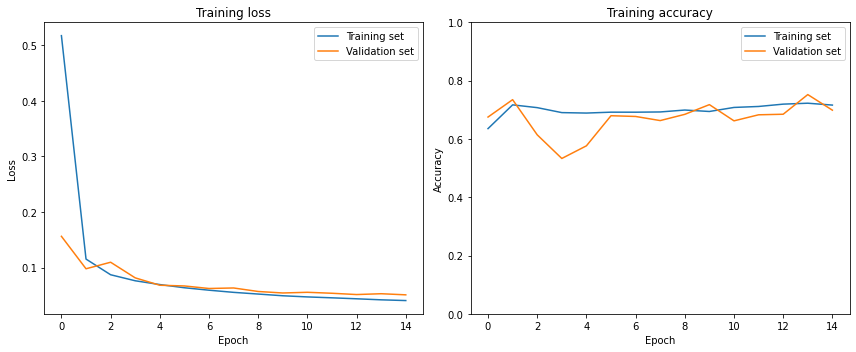

In [52]:
draw_train_history(tracker_NN.history)


### Examine output
Example for seed #0

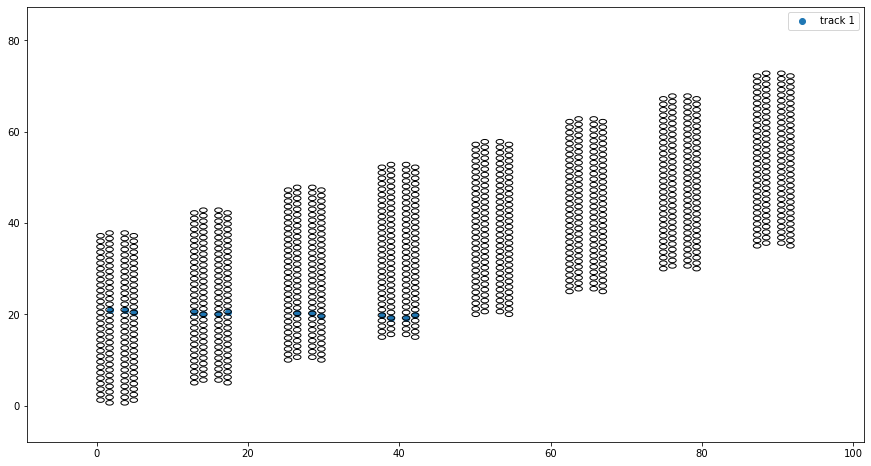

In [53]:
i_evt=0
display_event(tracker, evts_hits[i_evt], evts_ids[i_evt])

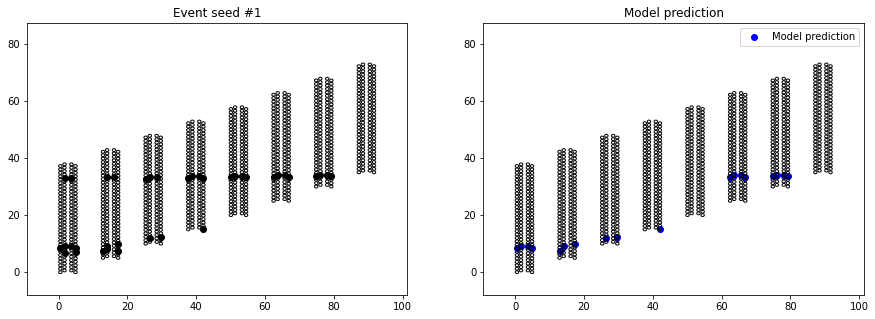

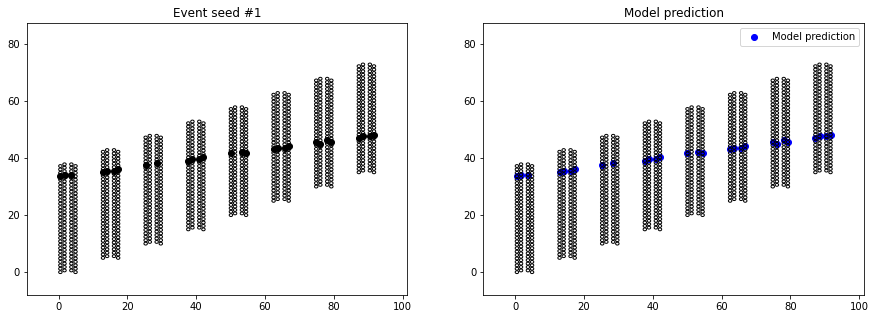

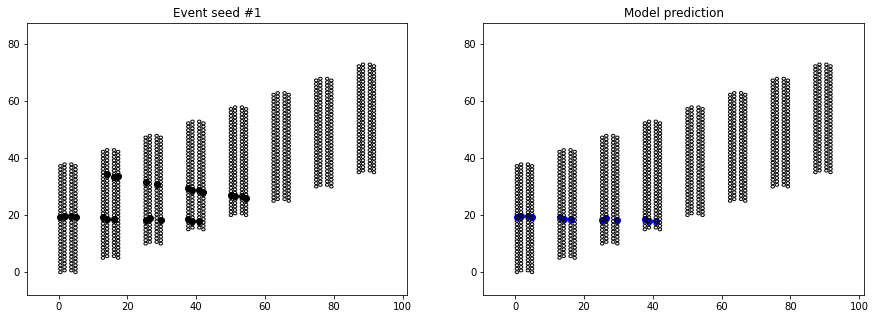

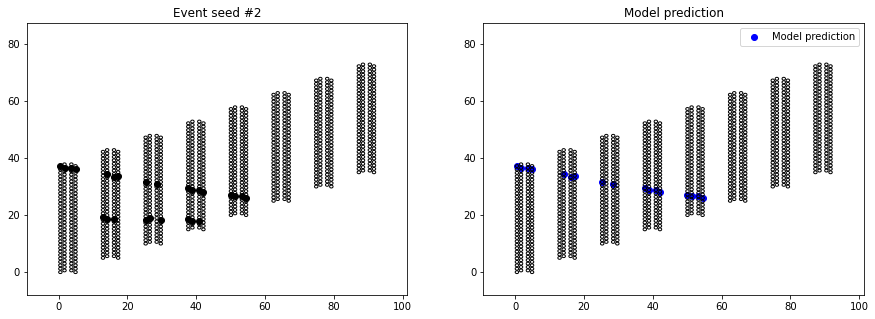

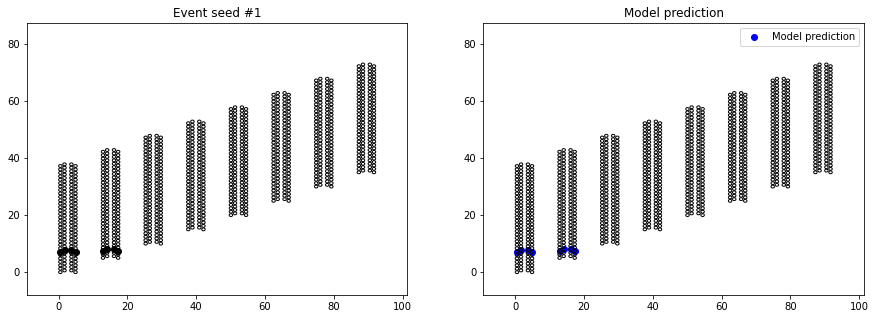

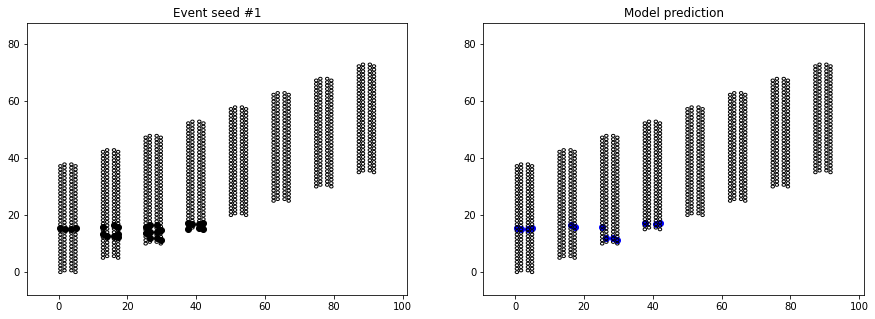

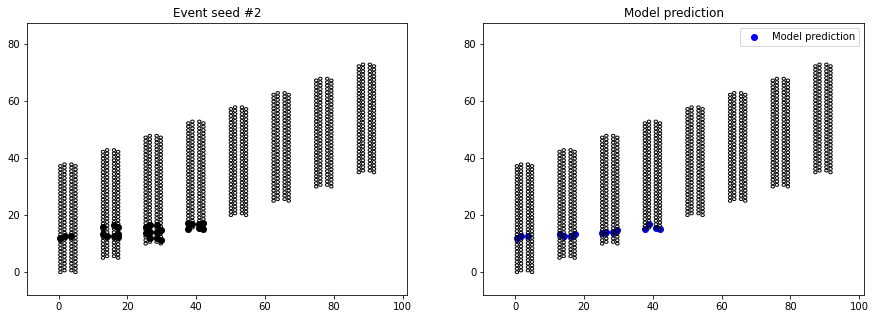

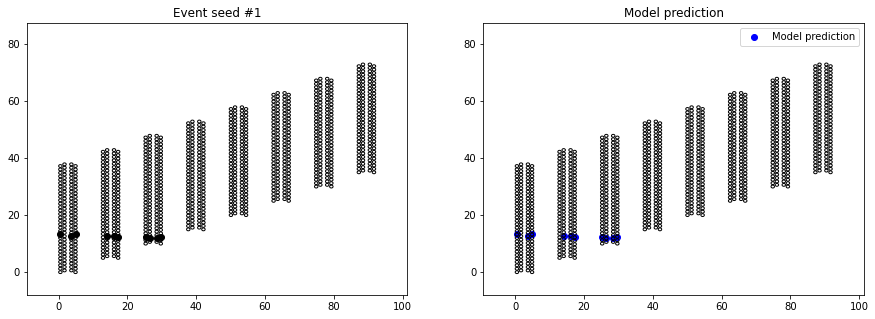

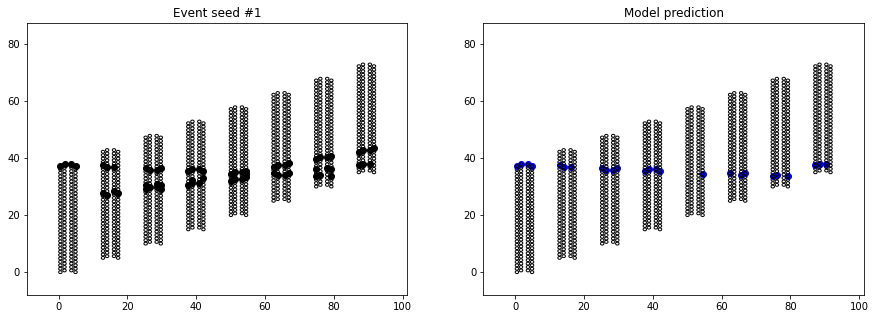

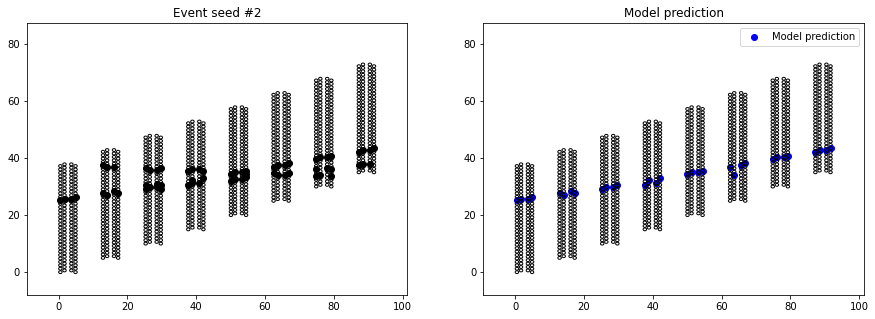

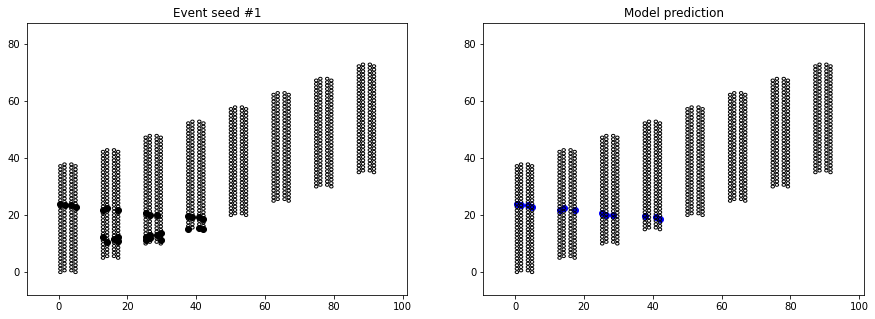

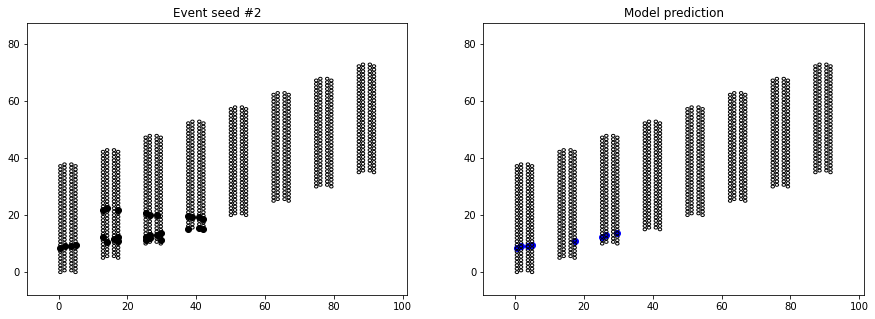

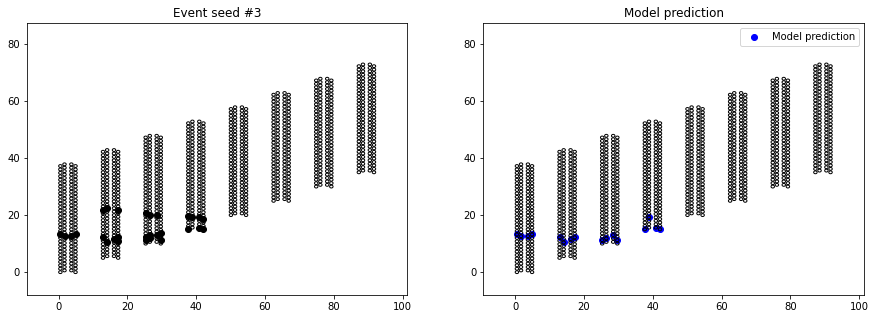

In [54]:
range_start=0
for i in range(range_start,range_start+10):
    tracker_NN.plot_event_and_prediction(evts_hits[i],evts_ids[i], figsize=(15,5))

In [204]:
print(tracker_NN.train_pred[0])

[[1.73105418e-05 4.25781873e-05 5.17188309e-05 2.30126425e-05
  6.08883238e-05 9.98270988e-01 4.35197398e-05 5.09125384e-05
  9.46947403e-05 2.44118361e-04 5.63690191e-05 9.71061672e-05
  9.96807721e-05 5.43362621e-05 5.84240333e-05 1.96152745e-04
  1.58421040e-04 1.21930447e-04 1.84306235e-04 7.36214279e-05]
 [1.57486191e-09 2.04735091e-08 3.71298441e-08 5.20247951e-08
  2.41114208e-07 9.99998093e-01 1.24655273e-07 4.11401686e-08
  5.03817645e-08 2.23266341e-07 2.40438531e-08 1.63789096e-07
  7.64362440e-09 7.11755099e-09 1.07349400e-08 1.53632186e-07
  3.66419272e-07 4.50017268e-08 3.50432856e-07 5.53326984e-08]
 [2.49217674e-10 2.19362084e-09 2.33450610e-08 3.81727858e-08
  3.29859294e-02 9.67011273e-01 7.76415220e-07 2.29752530e-07
  3.62079700e-09 6.28236663e-08 4.08057410e-08 2.27734020e-07
  2.51036081e-08 2.13362550e-09 3.31235590e-08 4.07057712e-08
  7.12019471e-07 3.19234175e-07 1.80441816e-07 1.51901673e-08]
 [8.11892789e-07 7.58328866e-08 1.90081357e-06 2.71048589e-06
  1.2

## Build scoring function
The scoring function only examines hits in an event, assigns them to most likely seed in event

In [ ]:
i_evt=4
tracker.plot_event_and_prediction(evts_hits[i_evt],evts_ids[i_evt], figsize=(20,3))

In [55]:
def score_function(true_ids, predicted_ids):
    '''
    Calculate an accuracy score based on hits within events, which belong to seeded tracksa.
    Both true and predicted ids are of shape (n_evts, length, width).
    Accuracy score is calculated as the fraction of correctly assigned hits.
    '''
    n_trackhits, n_trackhits_correct=0,0
    n_predicted,n_predicted_correct=0,0
    
    n_evts=true_ids.shape[0]
    
    for i_evt in range(n_evts):
        
        ## get all seeds in this event
        seeds=make_seeds(true_ids[i_evt])
        seed_ids = np.unique([x for x in seeds[0] if x>0])
        n_seeds = len(seed_ids)
        if n_seeds==0: continue
        
        for seed_id in seed_ids:
            # all hits from the track with this seed
            layers,straws=np.where(true_ids[i_evt]==seed_id)
            n_trackhits += len(layers)
            
            # of these hits, get those predicted correctly
            # (exact seed id # doesn't have to match the "truth", just the seed)
            predicted_seed = predicted_ids[i_evt][layers[0]][straws[0]]## currently a little problematic, as it is possible for the 0th layer hit to be misidentified (ie not of the seed)
            n_trackhits_correct += len( np.where(predicted_ids[i_evt][layers,straws]==predicted_seed)[0] )
            
            # number of predicted hits in track
            layers,straws=np.where(predicted_ids[i_evt]==predicted_seed)
            n_predicted += len(layers)
            
            # of the predicted hits, get those that are correct
            n_predicted_correct += len( np.where((predicted_ids[i_evt]==predicted_seed) &
                                                (true_ids[i_evt]==seed_id))[0] )
    
    if n_trackhits==0:
        print('No seeds found in events passed')
        return 0
    
    print('Fraction of track hits identified correctly: ', n_trackhits_correct/n_trackhits)
    print('Fraction of predicted hits that belong to the correct track: ', n_predicted_correct/n_predicted)
    return n_predicted_correct/n_predicted



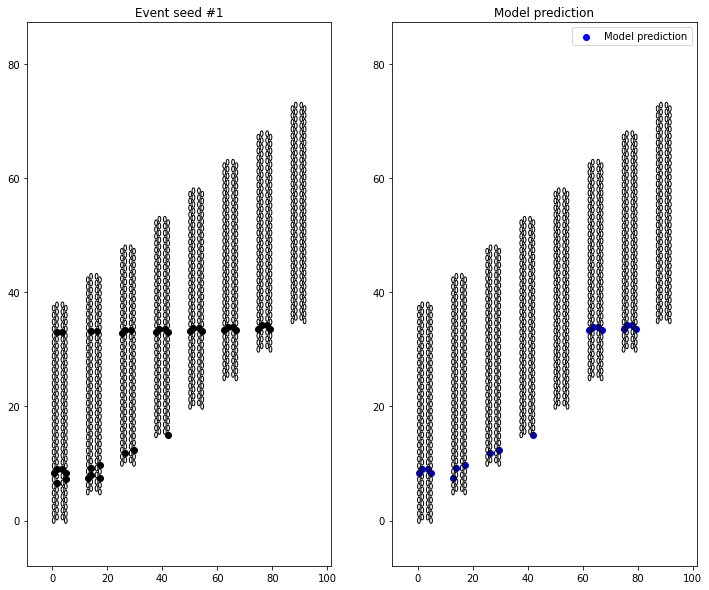

Fraction of track hits identified correctly:  0.7142857142857143
Fraction of predicted hits that belong to the correct track:  0.2777777777777778


0.2777777777777778

In [63]:
i_evt=1
tracker_NN.plot_event_and_prediction(evts_hits[i_evt],evts_ids[i_evt], figsize=(12,10))
predicted_ids=np.zeros(shape=(1,evts_hits[0].shape[0],evts_hits[0].shape[1] ))
predicted_ids[0]=tracker_NN.predict_event_ids(evts_hits[i_evt], evts_ids[i_evt])
evt_ids=np.zeros_like(predicted_ids)
evt_ids[0]=evts_ids[i_evt]
score_function(evt_ids, predicted_ids )

In [61]:
predicted_ids=tracker_NN.predict_ids(evts_hits, evts_ids)
score_function(evts_ids, predicted_ids )

Fraction of track hits identified correctly:  0.898925463190217
Fraction of predicted hits that belong to the correct track:  0.19295640673592424


0.19295640673592424

## Notes on current status

Looks like we are doing worse than before.  
The fraction of track hits that are identified correctly is doing a little bit worse, 90% down from ~95%.  
But we are really doing worse on the fraction of predicted hits that actually belong to the correct track.  

This arises out of the updated geometry, for two reasons:
1) I didn't update the direction of generated tracks, which means that the detector geometry is now not optimized to detect these tracks, likely resulting in missing the first layers on a few tracks.  
2) Increased requirement of 3 hits per seed, meaning it's even more likely that many tracks will have missed their seed.  

Both result in many more "unclaimed" hits, which are very likely to be claimed by existing seeded track searches, resulting in errors. This is a well understood mechanism.  

Improvements needed:
1) Search for seeds anywhere in the tracker. That will ensure that most tracks are searched for, and therefore there will be much fewer unclaimed hits.  
2) The above is doubly important!  
3) Improve pseudotrack generation, make it more symmetric to the detector's directionality.  
4) Add cleanup for hits that are impossible to belong to teh same track as the seed, after taking into account an average track directionality. That is probably too algorithmic and clunky to impose.

In [ ]:
'''
as used in the HEPTrkX

## prepare training input and labels
train_events = np.zeros((n_training_events, 1, det.length, det.width))
train_targets = -99 * np.ones((n_training_events, det.length, det.width))
train_weights = np.zeros((n_training_events, det.length, det.width))

for i_event in range(n_training_events):
    train_events[i_event,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
    event_targets = np.asarray(targets[:num_tracks])
    train_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
    train_weights[n,:num_tracks] = np.ones((num_tracks))
'''



In [ ]:

'''
def build_model_1():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=events_hits[0].shape)
    layer = layers.Convolution1D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution1D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    #layer = layers.MaxPooling2D(pool_size=(2,2))(layer) ## no pooling layers - they will reduce the dimension
    layer = layers.Convolution1D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution1D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(mean_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)

    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

model = Sequential()
model.add(Conv1D(64, 
                 kernel_size=3, 
                 activation="relu", 
                 padding='same',
                 input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Conv1D(32, 
                 kernel_size=3, 
                 activation="relu",
                 padding='same'))
'''

In [67]:
# Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Conv2D, Conv3D, Activation, MaxPooling1D, MaxPooling2D
from keras.optimizers import Adam

input_shape=events_hits[0].shape


class Model_Conv1D():
    '''
    A convolutional NN with Conv1D layers.
    Currently does poorly. 
    Weirdly it does worst with more complexity and an extra convolutional layer, 
    compared to just two simple Conv1D.
    **** TO DO:
        ** set weights, according to the HEPTrkX example
        ** set seeds
        ** try different compilation, ie loss, optimizer...
    
    Probably not great to use 1D for a 2D picture of the tracker.
    Better to try adding a dummy dimension (corresponding to the "value" of each straw, ie whether hit or not)
    and do a Conv2D model. 
    (this is done in the next model cell)
    '''
    
    def __init__(self):
        self.learning_rate = 0.001
        self.build_model()

    def build_model(self):
        self.model = Sequential()

        ## Sequential applications of convolutional layer, followed by non-linearity, followed by pooling
        self.model.add(
            Conv1D(20, 
                   kernel_size=10, 
                   activation="relu", 
                   padding='same',
                   input_shape=input_shape )
        )
        self.model.add(Activation('relu'))
        self.model.add(
            MaxPooling1D(pool_size=2,strides=1,padding='same')
        )

        self.model.add(
            Conv1D(40, 
                   kernel_size=6, 
                   activation="relu",
                   padding='same')
        )
        self.model.add(Activation('relu'))
        self.model.add(
            MaxPooling1D(pool_size=2,strides=1,padding='same')
        )

        self.model.add(
            Conv1D(input_shape[-1], 
                   kernel_size=3, 
                   activation="relu",
                   padding='same')
        )
        self.model.add(Activation('relu'))
        self.model.add(
            MaxPooling1D(pool_size=2,strides=1,padding='same')
        )

        self.model.summary()
        #self.model.compile(loss='categorical_crossentropy', optimizer='adam')
        self.model.compile(loss='mse', 
                           optimizer=Adam(lr=self.learning_rate),
                           metrics=['accuracy'])

nn_Conv1D = Model_Conv1D()

#        model.fit(X_train, y_train)



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 30, 20)            10020     
_________________________________________________________________
activation_18 (Activation)   (None, 30, 20)            0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 30, 20)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 30, 40)            4840      
_________________________________________________________________
activation_19 (Activation)   (None, 30, 40)            0         
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 30, 40)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 30, 50)           

In [43]:
events_hits[0].shape

(30, 50)

In [54]:
train_data_2D=np.asarray(events_hits)
dim1,dim2,dim3=train_data_2D.shape[:3]
train_data_2D=train_data_2D.reshape(dim1, dim2, dim3,1)
train_data_2D.shape

(48663, 30, 50, 1)

In [66]:
## Another model using Conv2D

train_data_2D=np.asarray(events_hits)
dim1,dim2,dim3=train_data_2D.shape[:3]
train_data_2D=train_data_2D.reshape(dim1, dim2, dim3,1)
input_shape=train_data_2D.shape

class Model_Conv2D():
    '''
    **** TO DO:
        ** add seeds!
        ** try locally connected layers, at least at first layers. Could be more suited to task.
        (would still probably need fully connected for deeper layers)'''
    def __init__(self):
        self.learning_rate = 0.001
        self.build_model()

    def build_model(self):
        self.model = Sequential()

        ## Sequential applications of convolutional layer, followed by non-linearity, followed by pooling
        self.model.add(
            Conv2D(32, 
                   kernel_size=(5,5), 
                   activation="relu", 
                   padding='same',
                   input_shape=input_shape )
        )
        self.model.add(
            Conv2D(64, 
                   kernel_size=(5,5), 
                   activation="relu", 
                   padding='same' )
        )
        self.model.add(
            MaxPooling2D(pool_size=(2,2),strides=1,padding='same')
        )
        
        self.model.add(
            Conv2D(128, 
                   kernel_size=(3,3), 
                   activation="relu", 
                   padding='same',
                   input_shape=input_shape )
        )
        self.model.add(
            Conv2D(256, 
                   kernel_size=(3,3), 
                   activation="relu", 
                   padding='same' )
        )
        self.model.add(
            MaxPooling2D(pool_size=(2,2),strides=1,padding='same')
        )





### Test layers

In [20]:
conv_layer_input = Conv1D(40, kernel_size=3, 
                          activation='relu',
                          padding='same',
                          input_shape=events_hits[0].shape ) (events_hits)
conv_layer_input.shape

TensorShape([48663, 30, 40])

In [25]:
from keras.layers import Activation
activation=Activation('relu')(conv_layer_input)
activation.shape

TensorShape([48663, 30, 40])

In [30]:
from keras.layers import MaxPooling1D
maxpooling=MaxPooling1D(pool_size=2,strides=1,padding='same')(activation)
maxpooling.shape


TensorShape([48663, 30, 40])

In [295]:
conv_layer_middle = Conv1D(det.width, kernel_size=3, 
                          activation='relu',
                          padding='same' ) (conv_layer_input)
conv_layer_middle.shape

TensorShape([9745, 30, 50])

In [68]:
train_data_2D=np.asarray(events_hits)
dim1,dim2,dim3=train_data_2D.shape[:3]
train_data_2D=train_data_2D.reshape(dim1, dim2, dim3,1)
input_shape=train_data_2D.shape

conv2D_layer_input = Conv2D(40, kernel_size=(3,3), 
                          activation='relu',
                          padding='same',
                          input_shape=input_shape ) (train_data_2D)
conv2D_layer_input.shape

TensorShape([48663, 30, 50, 40])

## Fit and plot history

In [64]:
history = nn_Conv1D.model.fit(
    events_hits, events_ids,
    epochs=50,
    #verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/50
1217/1217 [==============================] - 15s 12ms/step - loss: 0.0754 - accuracy: 0.7105 - val_loss: 0.0868 - val_accuracy: 0.6914
Epoch 2/50
1217/1217 [==============================] - 16s 13ms/step - loss: 0.0754 - accuracy: 0.7106 - val_loss: 0.0870 - val_accuracy: 0.6931
Epoch 3/50
1217/1217 [==============================] - 16s 13ms/step - loss: 0.0753 - accuracy: 0.7107 - val_loss: 0.0875 - val_accuracy: 0.6905
Epoch 4/50
1217/1217 [==============================] - 15s 13ms/step - loss: 0.0753 - accuracy: 0.7106 - val_loss: 0.0871 - val_accuracy: 0.6911
Epoch 5/50
1217/1217 [==============================] - 16s 13ms/step - loss: 0.0754 - accuracy: 0.7109 - val_loss: 0.0867 - val_accuracy: 0.6899
Epoch 6/50
1217/1217 [==============================] - 20s 16ms/step - loss: 0.0753 - accuracy: 0.7112 - val_loss: 0.0866 - val_accuracy: 0.6925
Epoch 7/50
1217/1217 [==============================] - 23s 19ms/step - loss: 0.0752 - accuracy: 0.7110 - val_loss: 0.0870 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


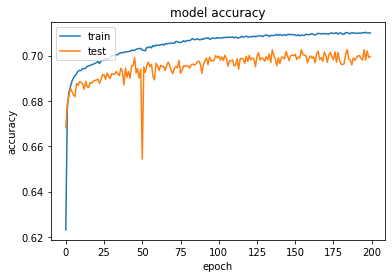

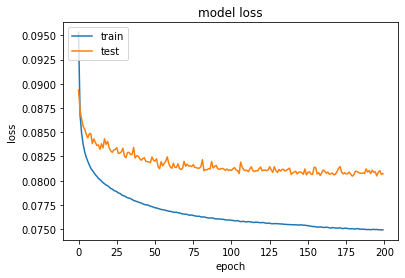

In [60]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
predict_ids=nn_2D.model.predict(events_hits)

## for now round predictions, though the decimal part could be interpreted
predict_ids=np.rint(predict_ids)
predict_ids

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [42]:
nn_2D.model.get_weights()

[array([[[-3.28366935e-01,  9.88107398e-02, -4.62551713e-02, ...,
          -7.01222615e-03, -5.28660901e-02,  3.90528068e-02],
         [-1.58148634e+00,  3.49321961e-02,  1.48382440e-01, ...,
           2.05728356e-02,  3.21738511e-01,  7.03698397e-02],
         [-2.67852038e-01,  1.03847578e-01, -6.31179512e-02, ...,
           1.35043589e-02,  1.01031214e-01,  1.14803746e-01],
         ...,
         [ 2.77482904e-03,  6.86274841e-02,  1.10869086e-03, ...,
           1.75363243e-01,  1.17385380e-01,  3.64953913e-02],
         [ 1.35255456e-01, -1.56535059e-01, -1.79295644e-01, ...,
           8.56510177e-02,  1.55519277e-01,  7.47138485e-02],
         [ 1.42096030e-02, -2.38672659e-01, -1.51683465e-01, ...,
           6.37889504e-02,  4.56718951e-02,  1.20878309e-01]],
 
        [[ 2.65273660e-01,  9.93591964e-01, -1.85979620e-01, ...,
           3.16404700e-02, -7.08584264e-02, -2.67067440e-02],
         [ 3.35044742e-01,  3.15704347e-05,  1.35415763e-01, ...,
           2.16400120

Truth for event #0 ::


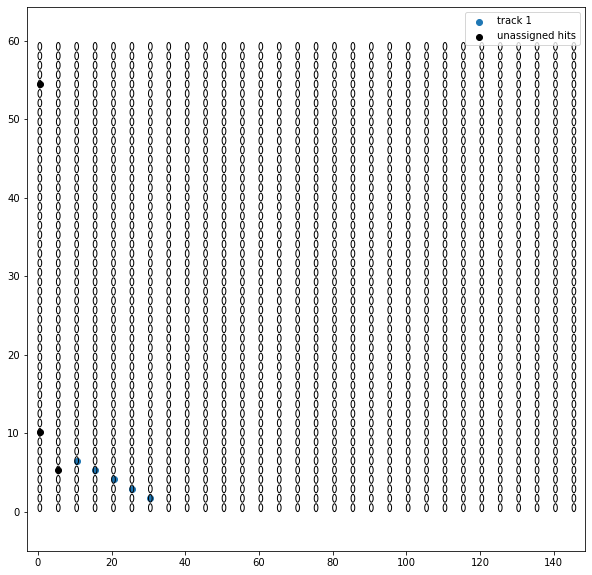

Prediction for event #0 ::


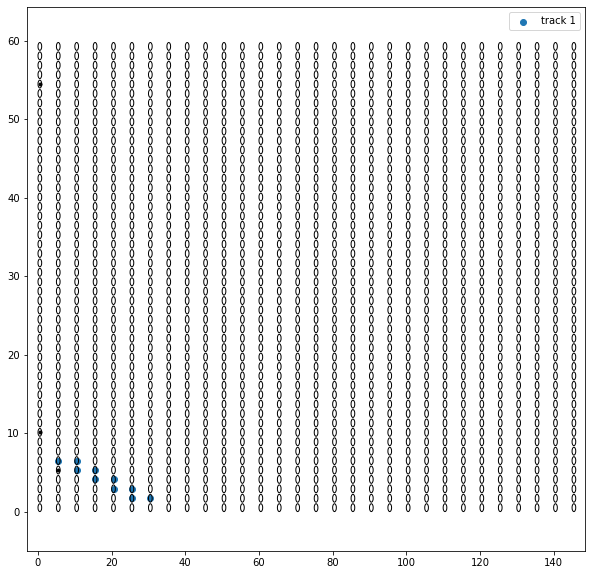

Truth for event #1 ::


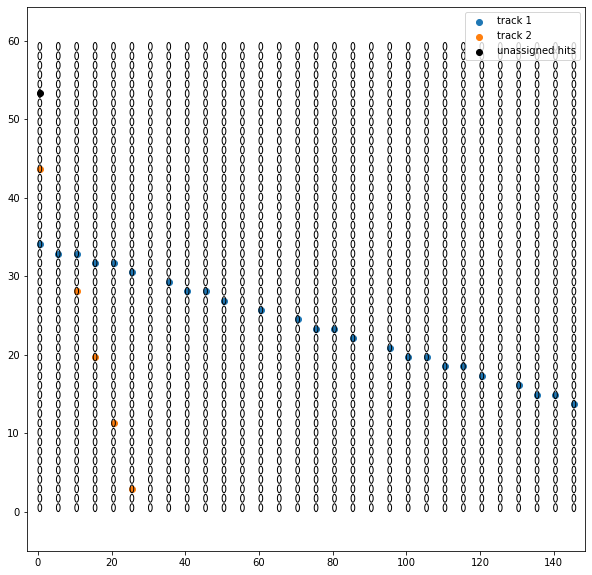

Prediction for event #1 ::


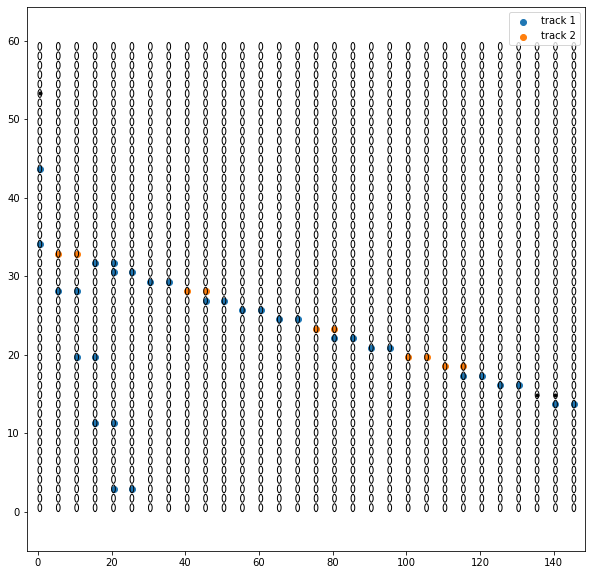

Truth for event #2 ::


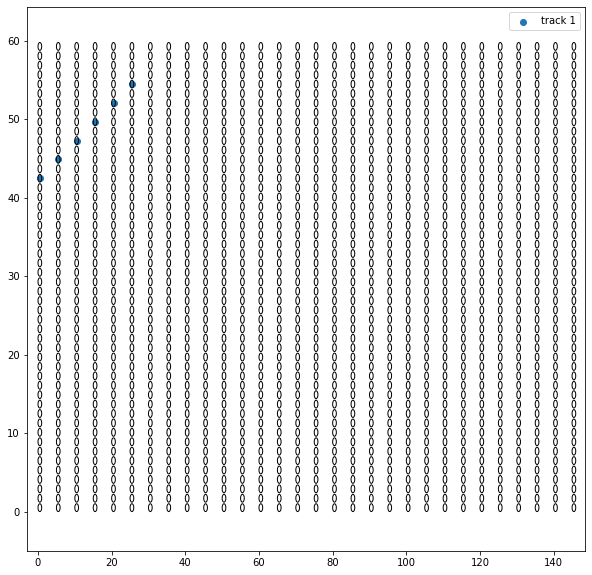

Prediction for event #2 ::


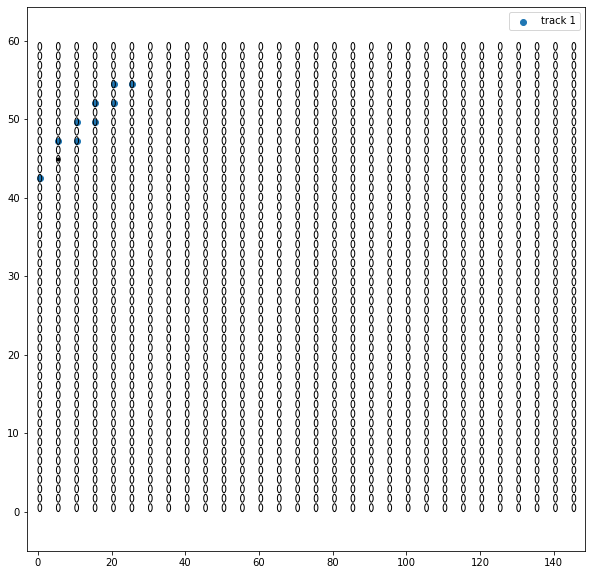

Truth for event #3 ::


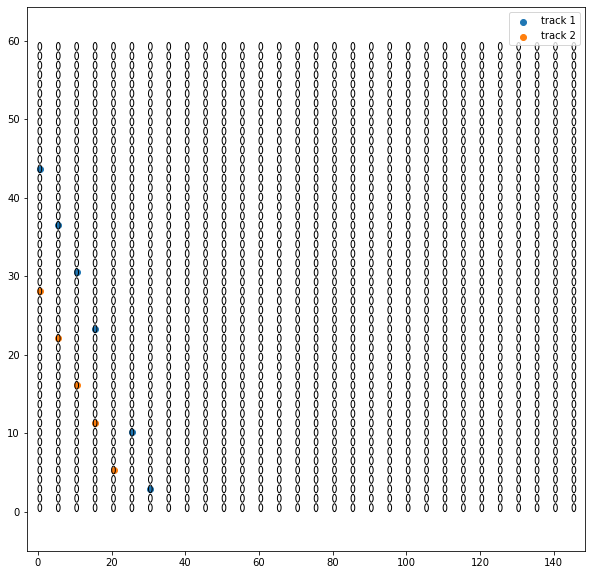

Prediction for event #3 ::


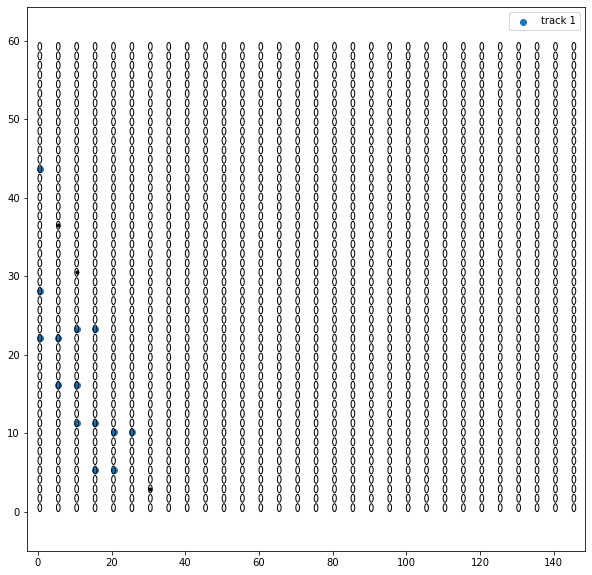

Truth for event #4 ::


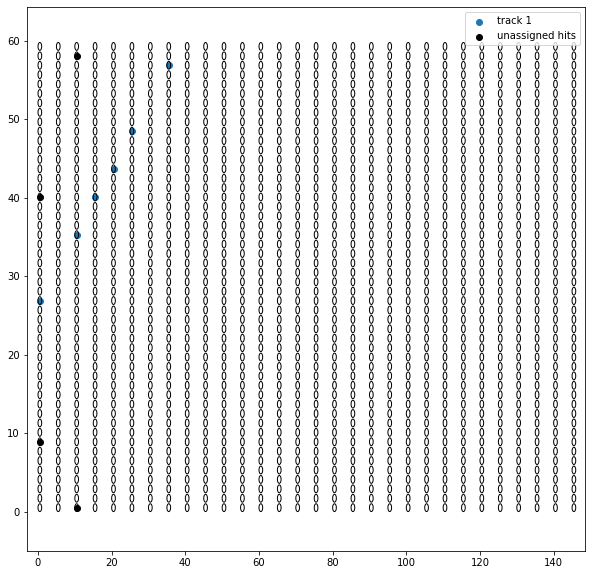

Prediction for event #4 ::


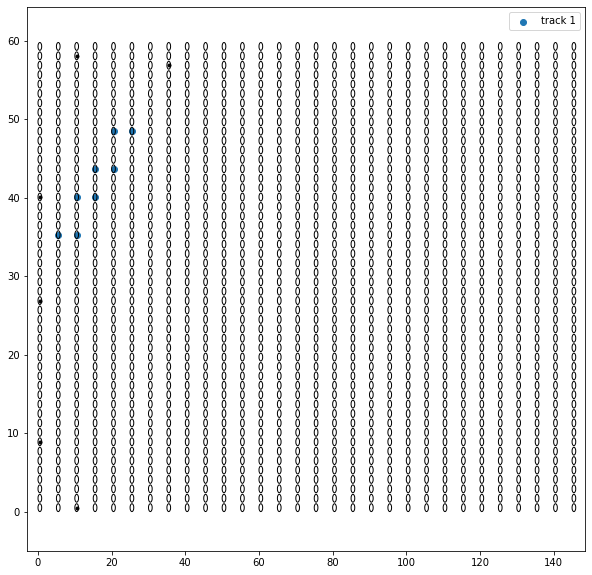

In [35]:
for i_evt in range(5):
    print ('Truth for event #%d ::'%i_evt)
    display_event(det, events_hits[i_evt], events_ids[i_evt])
    print ('Prediction for event #%d ::'%i_evt)
    display_event(det, events_hits[i_evt], predict_ids[i_evt])